In [1]:
from fasta_iterator_class import FASTAReader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

aa_seq = FASTAReader(open("mas.fa"))

DNA_seq = FASTAReader(open("seqdump.txt"))


# Question 3

In [2]:
#Making a dictory to store the sequence ID as the key, with the orginal sequence and translated sequence. 
sequence_dic = {}

for seq_id, sequence in DNA_seq:
    seq_id = seq_id.split()
    sequence_dic.setdefault(seq_id[0], [sequence])
    
    
for seq_id, sequence in aa_seq:
    seq_id = seq_id.split()
    sequence_dic[seq_id[0][:-2]].append(sequence) 


In [3]:
#Going from translated sequence to a aligned nucleotide sequence 
for i, j in sequence_dic.items():
    gap = ''
    position = 0
    amino_acids = j[1]
    
    for aa in amino_acids:
        if aa == "-":
            gap = gap + '---'#adding the gap
        else:
            gap = gap + j[0][position:position + 3]#will pull the 3 nucleotides(codon)
            position += 3#will advance to the next codon position
        
    sequence_dic[i].append(gap) 

In [4]:
print(sequence_dic["NC_001563.2"][2])

---------------------------------------------------------------------------------------------------------------AGTAGTTCGCCTGTG------------------------------------------------------------------TGAGCTGACAAACTTAGTAGTGTT------------------TGTGAG---GATTAACAACAA------------------------TTAACACAGTGCGAGCTGTTTCTTGGCACGAAGATCTCGATGTCT------------------------AAGAAACCA---------GGAGGGCCCGGTAAAAACCGGGCTGTCAATATGCTAAAA---CGCGGT---ATGCCCCGCGGATTGTCCTTGATAGGA------------------------CTAAAGAGGGCTATGCTGAGT---------------------------------CTGATTGACGGGAAGGGCCCAATACGTTTCGTGTTGGCTCTTTTGGCGTTTTTCAGATTCACTGCAATC---GCTCCGACTCGTGCGGTGCTGGACAGATGGAGAGGCGTCAACAAACAAACAGCAATGAAGCATCTCTTGAGTTTCAAGAAAGAACTAGGAACTCTGACCAGTGCCATCAACCGCCGGAGCACAAAACAAAAGAAAAGAGGAGGCACAGCGGGCTTTACTATCTTGCTTGGGCTGATCGCCTGTGCTGGAGCTGTGACCCTCTCGAACTTCCAGGGCAAAGTGATGATGACAGTCAATGCAACCGATGTCACTGACGTGATTACCATTCCAACAGCTGCTGGGAAAAACCTGTGCATCGTAAGGGCTATGGACGTAGGATACCTTTGTGAGGATACTATCACTTATGAATGTCCGGTC---CTAGCTGCTGGAAATGACCCTGAAGACATTGACTGCTGGTGCACGA

# Question 4
# Determining the dN and dS values

In [5]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [6]:
original = sequence_dic["NC_001563.2"][2]

dS_vals = []
dN_vals = []

for i in range(0,len(original),3):
    if original[i] == '-':#skip in the orginal where there is a gap
        continue
    else:
        dS = 0
        dN = 0
        
        for names, seqs in sequence_dic.items():
            if seqs[2][i:i+3] == '---': #skip gaps in reference 
                continue
            elif original[i:i+3] == seqs[2][i:i+3]: #check for matching nucleotide sequence 
                continue
            else:
                if seqs[2][i:i+3] not in codontable: #skip over any weird codons
                    continue
                elif codontable[original[i:i+3]] == codontable[seqs[2][i:i+3]]:
                    dS += 1
                else:
                    dN += 1
            
        dS_vals.append(dS)
        dN_vals.append(dN)



    

- just checking out that the lengths make sense

In [7]:
len(dS_vals)

3642

In [8]:
len(dN_vals)

3642

In [9]:
import numpy as np

# Calculating D and z-scores

- orginally I planned on using numpy arrays, but pandas made it easier

In [10]:
dn = np.array(dN_vals)
ds = np.array(dS_vals)
data_values = pd.DataFrame(data = [dn, ds])
data_values = data_values.T.rename(columns={0:'dN', 1:'dS'})#Make a frame with the orginal dN and dS list
data_values

data_values = data_values.loc[data_values["dS"] != 0]#Remove rows where dS is 0
data_values = data_values.loc[data_values["dN"] != 0]#Remove rows where dN is 0
data_values["dN/dS"] = data_values['dN']/data_values['dS']#calculate the dN/dS ratios
data_values['D'] = data_values['dN'] - data_values['dS']#calculate D scores
data_values['log2 ratio'] = np.log2(data_values["dN/dS"])#make a column and transform ratios with log2
data_values['z-score'] = stats.zscore(data_values['D'])#calculate the z-scores of D values
data_values['index'] = range(len(data_values))#was possibly going to use this for graphing purposes

data_values


,dN,dS,dN/dS,D,log2 ratio,z-score,index
0,160,36,4.444444,124,2.152003,-0.751256,0
1,50,13,3.846154,37,1.943416,-1.109010,1
2,200,7,28.571429,193,4.836501,-0.467520,2
3,212,2,106.000000,210,6.727920,-0.397614,3
5,212,10,21.200000,202,4.405992,-0.430511,4
...,...,...,...,...,...,...,...
3631,1,1,1.000000,0,0.000000,-1.261159,3141
3637,75,12,6.250000,63,2.643856,-1.002095,3142
3639,143,5,28.600000,138,4.837943,-0.693687,3143
3640,405,14,28.928571,391,4.854423,0.346679,3144


# Plotting the log2 ratios over the codons, and coloring significant Ds

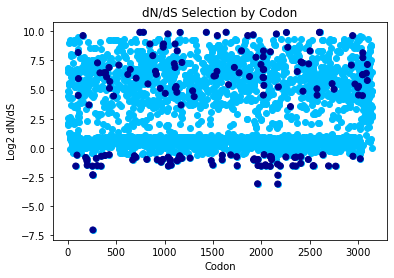

In [11]:
fig, ax = plt.subplots()

#The following z-score represents a p < 0.025, for a two-tailed test
colors = ['darkblue' if zscore > 1.96 or zscore < (-1.96) else 'None' for zscore in data_values['z-score']] 

ax.scatter(x = range(0, len(data_values)), y = data_values['log2 ratio'], color = 'deepskyblue')# non-significant points
ax.scatter(x = range(0, len(data_values)), y = data_values['log2 ratio'], color = colors) #The significant points

plt.title('dN/dS Selection by Codon')
plt.xlabel('Codon')
plt.ylabel('Log2 dN/dS')

plt.show()